<h1>This is not the latest version of the rules, start with the other notebook!</h1>
<p>keeping it around for now because it has a basic version of a player 'finding' the best move within a turn structure, and tracking how those optimal turns contribute to overall capial of the player 'company'</p>

In [ ]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt

def compare(ideal, actual):
    i = np.array(ideal)
    j = np.array(actual)
    diff = np.sqrt((i-j)**2)
    return sum(diff)

def random_name():
    first_names=('John','Andy','Joe','Tom','Michael','Tim','Bob','Frank','Sam','Jim','James','Lou','Conor','Jill','Jack','Serena','Mick','Ronald','Alphonse')
    last_names=('Johnson','Smith','Williams','McGrath','Dowd','Sinclair','Frank','Roberts','O Shea','Wallace','Jones','Stevens','Sinclair')
    name = random.choice(first_names) + " " + random.choice(last_names)
    return name

In [30]:
class Deck:
    def __init__(self, cards):
        self.cards = cards

    def take_N(self, N):
        res = []
        for i in range(N):
            x = random.choice(self.cards)
            self.cards.remove(x)
            res.append(x)
        return res

    def remove_X(self, Card):
        self.cards.remove(Card)

    def take_N_from_bottom(self, N):
        res = self.cards[0:N]
        self.employees = self.employees[N:]
        return res

    def add_N_to_bottom(self, cards):
        self.cards = cards + self.cards

    def take_N_from_top(self, N):
        res = self.cards[len(self.cards)-N:]
        self.cards = self.cards[0:len(self.cards)-N]
        return res

    def add_N_to_top(self, cards):
        self.cards = self.cards + cards 

class EmployeeCard:
    def __init__(self, name, department, productivity, salary, level, product_bonus_name, product_bonus):
        self.name = name
        self.department = department
        self.productivity = productivity
        self.salary = salary
        self.level = level
        self.product_bonus_name = product_bonus_name
        self.product_bonus = product_bonus
        
    def print(self):
        print('name: ' + self.name + ', dep: ' + self.department + ', level: ' + str(self.level) + ', prod: ' + str(self.productivity) + ', salary: ' + str(self.salary) + ', bonus: ' + self.product_bonus_name + ', bonus value: ' + str(self.product_bonus))

class EmployeeDeck:
    def __init__(self, game_settings, shuffle = False, no_l1_per_dep = 24, no_l2_per_dep = 12, no_l3_per_dep = 6):
        self.level_salary_mapping = game_settings['level_salary_mapping']
        self.level_productivity_mapping = game_settings['level_productivity_mapping']
        self.level_product_bonus_mapping = game_settings['level_product_bonus_mapping']
        self.no_l1_per_dep = no_l1_per_dep
        self.no_l2_per_dep = no_l2_per_dep
        self.no_l3_per_dep = no_l3_per_dep
        self.employees_level1 = self.generate_employees(1, no_l1_per_dep)
        self.employees_level2 = self.generate_employees(2, no_l2_per_dep)
        self.employees_level3 = self.generate_employees(3, no_l3_per_dep)
        self.employees = self.employees_level1 + self.employees_level2 + self.employees_level3
        if shuffle:
            random.shuffle(self.employees)
        
    def generate_employees(self, level, no_per_dep):
        res = []
        one_third = no_per_dep / 3
        for i in range(no_per_dep):
            for department in ['operations', 'engineering', 'sales']:
                name = random_name()
                salary = self.level_salary_mapping[level]
                productivity = self.level_productivity_mapping[level]
                product_bonus = self.level_product_bonus_mapping[level]
                
                if i % 3 == 0: # one third of level 2 cards get a bonus to cost
                    product_bonus_name = 'cost'
                elif i % 3 == 1: # one third of level 2 cards get a bonus to quality
                    product_bonus_name = 'quality'
                else: # one third of level 2 cards get a bonus to brand
                    product_bonus_name = 'brand'
                employee = EmployeeCard(name, department, productivity, salary, level, product_bonus_name, product_bonus)
                res.append(employee)
        return res

    def take_N_from_bottom(self, N):
        res = self.employees[0:N]
        self.employees = self.employees[N:]
        return res

    def add_N_to_bottom(self, employees):
        self.employees = employees + self.employees

    def take_N_from_top(self, N):
        res = self.employees[len(self.employees)-N:]
        self.employees = self.employees[0:len(self.employees)-N]
        return res

    def add_N_to_top(self, employees):
        self.employees = self.employees + employees 
        
    def take_N(self, N):
        res = []
        for i in range(N):
            x = random.choice(self.employees)
            self.employees.remove(x)
            res.append(x)
        return res
        
    def mix_in(self, EmployeeCards):
        self.employees = self.employees + EmployeeCards

class Calculator:
    def __init__(self):
        self

class Company:
    def __init__(self,
                 starting_capital, 
                 max_gross_mapping, # productivity in finance -> max gross income
                 max_prod_mapping, # nproductivity in engineering -> max produced units
                 max_sales_mapping, # productivity in sales -> max possible sales
                 brand_mapping, # sum brand points -> demand
                 quality_mapping, # sum quality points -> demand
                 cost_mapping, # cost reduction -> unit cost
                 price_demand_mapping # price -> demand
                ):
        
        self.employees = []
        self.allowed_prices = [i for i in price_demand_mapping]
        self.current_price = 5
        self.capital = starting_capital
        self.max_gross_mapping =  max_gross_mapping # productivity in finance department
        self.max_prod_mapping = max_prod_mapping # productivity in sales department
        self.max_sales_mapping = max_sales_mapping # productivity in sales department
        self.brand_mapping = brand_mapping
        self.quality_mapping = quality_mapping
        self.cost_mapping = cost_mapping
        self.price_demand_mapping = price_demand_mapping
        
    def get_max_key_and_value(self, dictionary):
        max_key, max_val = 0, 0
        for key in dictionary:
            if key > max_key:
                max_key = key
                max_val = dictionary[key]
        return max_key, max_val
                
    def hire_employee(self, employee, sign_on_bonus = 0):
        self.capital -= sign_on_bonus
        self.employees.append(employee)

    def get_productivity(self, employees, department):
        res = 0
        for emp in employees:
            if emp.department == department:
                res += emp.productivity
        return res

    def get_product_bonus(self, employees, product_bonus_name):
        res = 0
        for emp in employees:
            if emp.product_bonus_name == product_bonus_name:
                res += emp.product_bonus
        return res

    def get_total_salaries(self, employees):
        res = 0
        for emp in employees:
            res += emp.salary
        return res
    
    # Simplified net income calculation (assuming fixed price and unit cost for now)
    def calculate_net(self, employees, price, debug = 0):
        quality = self.get_product_bonus(employees, 'quality')
        brand = self.get_product_bonus(employees, 'brand')
        cost = self.get_product_bonus(employees, 'cost')
        eng_productivity = self.get_productivity(employees, 'engineering')
        sales_productivity = self.get_productivity(employees, 'sales')
        ops_productivity = self.get_productivity(employees, 'operations')
        tot_salary = self.get_total_salaries(employees)
        
        if eng_productivity in self.max_prod_mapping:
            max_prod = self.max_prod_mapping[eng_productivity]
        else:
            max_prod = max(self.max_prod_mapping.values())
            
        if sales_productivity in self.max_sales_mapping:
            max_sales = self.max_sales_mapping[sales_productivity]
        else:
            max_sales = max(self.max_sales_mapping.values())
            
        if ops_productivity in self.max_gross_mapping:
            max_gross = self.max_gross_mapping[ops_productivity]
        else:
            max_gross = max(self.max_gross_mapping.values())
        
        if price in self.price_demand_mapping:
            price_demand = self.price_demand_mapping[price]
        else:
            raise('invalid price selected: ' + str(price))
            
        if quality in self.quality_mapping:
            quality_demand = self.quality_mapping[quality]
        else:
            quality_demand = max(self.quality_mapping.values())
            
        if brand in self.brand_mapping:
            brand_demand = self.brand_mapping[brand]
        else:
            brand_demand = max(self.brand_mapping.values())
            
        if cost in self.cost_mapping:
            unit_cost = self.cost_mapping[cost]
        else:
            unit_cost = min(self.brand_mapping.values())

        # calc
        demand = quality_demand + brand_demand + price_demand
        unit_profit = price - unit_cost
        units_sold = min([max_prod, max_sales, demand])
        potential_gross = units_sold * unit_profit
        actual_gross = min([potential_gross, max_gross])
        net = actual_gross - tot_salary
        if debug:
            print(' quality demand: ' + str(quality_demand) + ', brand demand: ' + str(brand_demand) + ', price demand: ' + str(price_demand) + ', price: ' + str(price) + ', unit cost: ' + str(unit_cost) + ', max prod: ' + str(max_prod) + ', max sales: ' + str(max_sales) + ', max gross: ' + str(max_gross))
            print(' tot salary: ' + str(tot_salary) + ', demand: ' + str(demand) + ', unit profit: ' + str(unit_profit) + ', unit sold: ' + str(units_sold) + ', potential gross: ' + str(potential_gross) + ', actual gross: ' + str(actual_gross) + ', NET: ' + str(net))
        return net

In [43]:
import copy
class GameSimulator:
    def __init__(self, game_settings, employeeDeck, players, turns, debug = False):
        #game set-up
        self.game_settings = game_settings
        self.employeeDeck = employeeDeck
        self.players = players
        self.turns = turns
        self.pool_size = game_settings['no_in_pool']

        self.capital_arrays = []
        
        # set up player variables
        self.companies = []

        for player in range(self.players):
            self.capital_arrays.append([])
            self.companies.append(Company(starting_capital = 10,
                                          max_gross_mapping=game_settings['max_gross_mapping'],
                                          max_prod_mapping = game_settings['max_prod_mapping'],
                                          max_sales_mapping = game_settings['max_sales_mapping'],
                                          brand_mapping = game_settings['brand_mapping'],
                                          quality_mapping = game_settings['quality_mapping'],
                                          cost_mapping = game_settings['cost_mapping'],
                                          price_demand_mapping = game_settings['price_demand_mapping']))
            
        # run game
        for turn_no in range(self.turns):
            if debug:
                print('turn: ' + str(turn_no) + ' total employees in deck: ' + str(len(self.employeeDeck.employees)) + ', draw: ' + str(self.pool_size) + ' employees')
            emp_pool = self.employeeDeck.take_N_from_bottom(self.pool_size)
            if debug > 1:
                print('total employees in deck: '+ str(len(self.employeeDeck.employees)))
                for emp in emp_pool:
                    emp.print()
                print()
            
            for player_ind in range(self.players):
                company = self.companies[player_ind]
                if debug:
                    print('player: ' + str(player_ind) + ', employees: ' + str(len(company.employees)) + ', capital: ' + str(company.capital))
                combo, price, net = self.find_best_combo_and_price(company, emp_pool, debug) # player finds best hires and price to maximise net income
                emps = []
                for ind in combo:
                    emps.append(emp_pool[ind])
                for emp in emps:
                    company.hire_employee(emp)
                    emp_pool.remove(emp) # remove them from the pool
                    
                # set price
                company.price = price

                # add net income to capital
                company.capital += net

                # track capital over turns
                self.capital_arrays[player_ind].append(company.capital)

            self.employeeDeck.add_N_to_top(emp_pool)

            if debug:
                print('--------------------------')

    def find_best_combo_and_price(self, company, available_employees, debug = 0):
        best_net, best_combo, best_price = -10000, [], 5
        current_net = company.calculate_net(company.employees, company.current_price, debug)

        test_combos = self.generate_doubles(len(available_employees))
        for test_combo in test_combos:
            test_emps = copy.deepcopy(company.employees)
            for ind in test_combo:
                test_emps.append(available_employees[ind])
            
            for price in company.allowed_prices:
                test_net = company.calculate_net(test_emps, price, False)
                if debug > 1 and price == 5:
                    print('Testing price: ' + str(price) + ', combination: Current Deck + ' + str(test_combo) + ', deck size: ' + str(len(test_emps)) + ', net: ' + str(test_net) + ', test_net: ' + str(test_net))
                if test_net > best_net:
                    best_net = test_net
                    best_combo = test_combo
                    best_price = price
                    if debug > 1:
                        print('new best set, best possible net: ' + str(best_net) + ', best combo: ' + str(best_combo) + ', best price: ' + str(best_price))
        if debug:
            print('best net income achieved: ' + str(best_net) + ', by hiring employees at indices: ' + str(best_combo) + ' and setting price to: ' + str(best_price))
            for ind in best_combo:
                test_emps = copy.deepcopy(company.employees)
                test_emps.append(available_employees[ind])
            test_net = company.calculate_net(test_emps, best_price, True)
        return best_combo, best_price, best_net
            
    def generate_doubles(self, no_employees):
        res = []
        #res.append([]) # this allows simulation to potentially do no hiring
        for i in range(no_employees):
            res.append([i])
            for j in range(i, no_employees):
                if i != j:
                    res.append([i,j])
        return res

In [128]:
game_settings = {
    'level_salary_mapping' : {1:2,2:3,3:4}, 
    'level_productivity_mapping': {1:1,2:2,3:2},
    'level_product_bonus_mapping': {1:1,2:1,3:2},
    'no_in_pool': 6,
    'max_gross_mapping' : {0:1,1:4,2:8,3:12,4:16,5:20,6:24,7:30,8:36}, # productivity in finance -> max gross income
    'max_prod_mapping' : {0:1,1:3,2:6,3:8,4:10,5:12,6:14,7:16,8:18}, # nproductivity in engineering -> max produced units
    'max_sales_mapping' : {0:1,1:3,2:6,3:8,4:10,5:12,7:16,8:18}, # productivity in sales -> max possible sales
    'brand_mapping' : {0:0,1:1,2:1,3:2,4:2,5:3}, # sum brand points -> demand
    'quality_mapping' : {0:0,1:1,2:1,3:2,4:2,5:3}, # sum quality points -> demand
    'cost_mapping' : {0:5,1:4,2:3,3:3,4:2,5:1}, # cost reduction -> unit cost
    'price_demand_mapping' : {1:5,2:4,3:4,4:3,5:3,6:2,7:2,8:1}, # price -> demand
}

---simulation time: 0.9079341888427734 seconds ---
Simulated : 20 games, with 12 turns, 1 player no competition or bidding
mean error from ideal progression: 201.45, std error from ideal: 62.466370952697424
average ending capital: 62.95


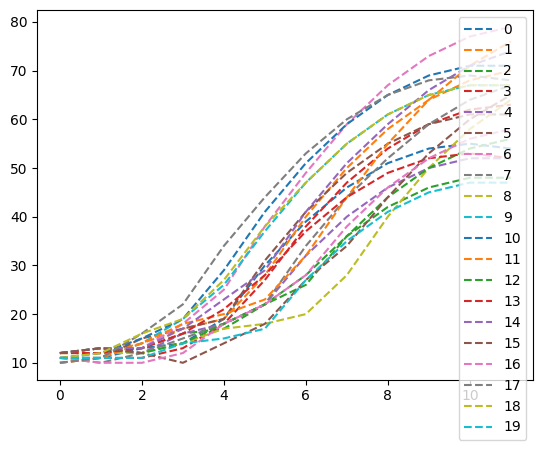

In [127]:
no_runs = 20
ideal = [9, 8, 9, 10, 12, 15, 18, 23, 26, 28, 29, 30] # ideal player capital over 12 turns
errors, final_caps = [], []

start_time = time.time()
for x in range(no_runs):
    deck = EmployeeDeck(game_settings, shuffle = True)
    game = GameSimulator(game_settings, deck, players = 1, turns = 12, debug = 0)
    final_caps.append(game.capital_arrays[0][-1])
    plt.plot(range(12), game.capital_arrays[0], label = str(x), linestyle="--")
    errors.append(compare(ideal, game.capital_arrays[0]))
print("---simulation time: %s seconds ---" % (time.time() - start_time))
print('Simulated : ' + str(len(errors)) + ' games, with 12 turns, 1 player no competition or bidding')
print('mean error from ideal progression: ' + str(np.mean(errors)) + ', std error from ideal: ' + str(np.std(errors)))
print('average ending capital: ' + str(np.mean(final_caps)))
plt.legend()
plt.show()